# Housing Prices Advanced Regression Techniques - Final Project Baseline 
### Spring 2022, Section 11 - Muhammad Ali Jawaid, Karthikeyan Ragunathan, Brendan Mattina 

### Introduction

For our final project, we will be analyzing the Kaggle Ames housing data set which has prices that houses were sold for in Ames, Iowa between 2006 to 2010. The data set also has information that describes the houses, such as year built, total basement square footage, etc. We will leverage this data set to build models to predict house sales prices. 

For our initial baseline, we established three baseline models, KNN regression, Decision Tree (DT) regressor, and linear regression. Based on our chosen metric of Root Mean Squared Error (RMSE), the Decision Tree Regressor was the best performing baseline model. Our next steps included: 
1. Feature engineering
2. Select most important features
3. Address missing data and determine if we need to focus on a property type, e.g. residential
4. Try new models (random forest, etc.)
5. Tune hyper-parameters to optimize existing baseline model performance
6. Try different ensemble approaches to combine models and improve overall performance

Since the baseline, we have expanded our project to encompass:
1. Dealing with missing data 
2. Normalizing data
3. Augmenting our initial set of models with Random Forest, AdaBoost, and stacking models
4. We had initially selected variables based on correlations. We re-ran our initial models with all variables and 
selected variables (normalized and not normalized)
5. We conducted feature engineering and ran models based on engineered features and variables with high correlation
6. We performed a case study on how Zillow struggled with their ML models, to glean lessons when operationalizing our models


### Step 1: Import libraries and data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
from sklearn.impute import KNNImputer

In [2]:
# import data
pd.set_option('display.max_colwidth', None)
housing_data = pd.read_csv("train.csv")


### Step 2: Exploratory Data Analysis

**Data Types and Missing Data**

In [3]:
# Display meta data
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Commentary:** There are 38 numerical values and 43 object values (appear to be text values based on housing_data.head()). There are 1460 records but some fields are missing values (do not have all 1460 values). 

Action item: 
1. Address missing values
2. Address object values by converting them to numerical values to feed machine learning algorithms
<br>

**Frequency and Distribution of Data**

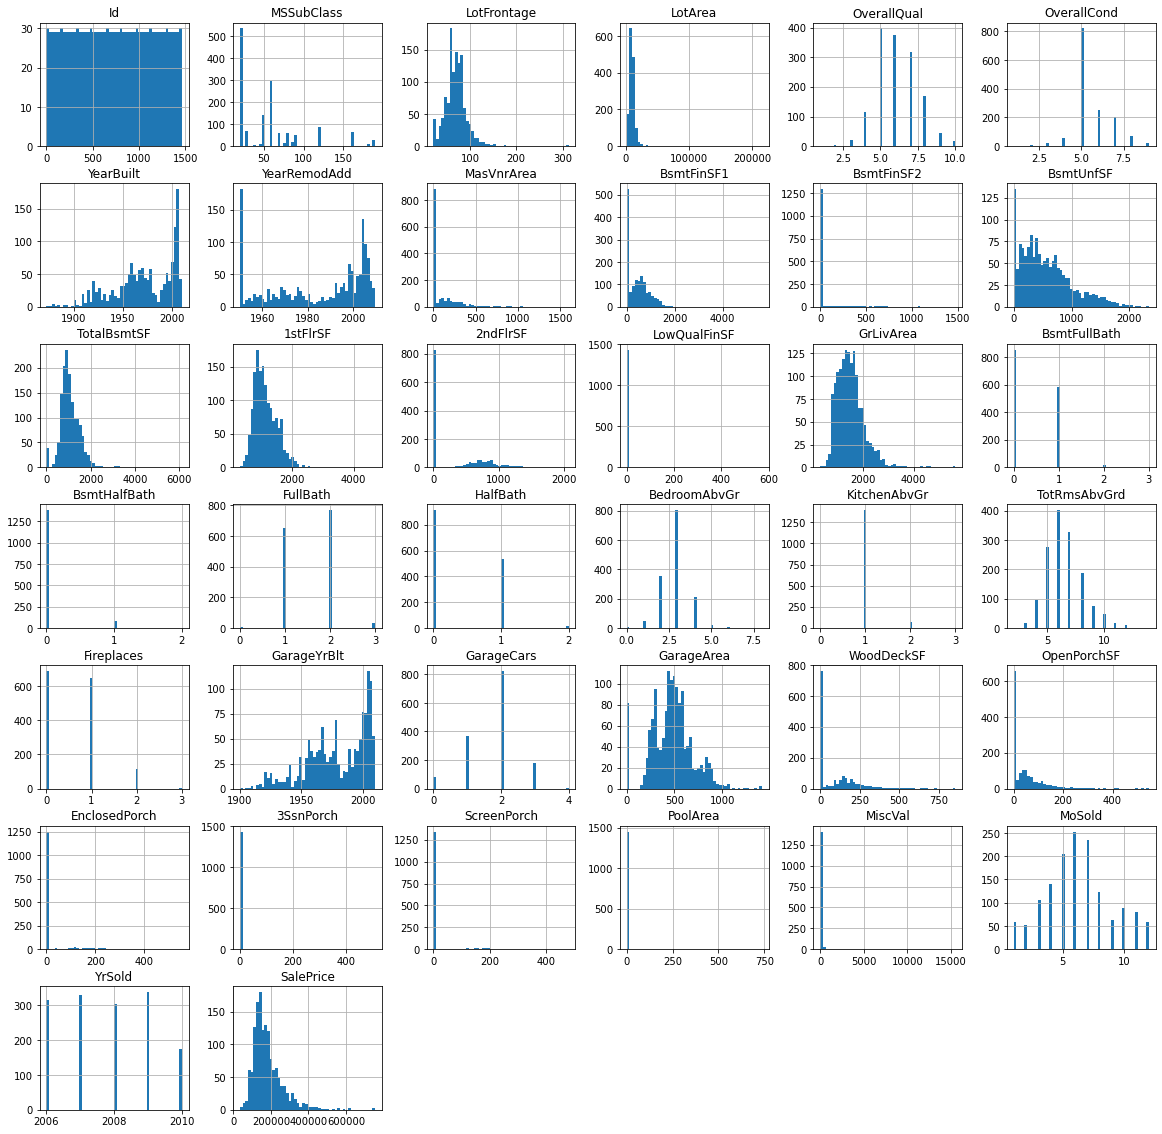

In [4]:
%matplotlib inline
housing_data.hist(bins=50, figsize=(20,20))
#save_fig("attribute_histogram_lots")
plt.show()

**Commentary:** The histograms lead to the following observations:
1. "SalePrice" is Right-Skewed.
2. There is an increasing number of "YearRemodAdd" or remodeling of homes that was done. Is this being done because residents want to improve their living standards or are they doing it because the cost spent on remodeling is an investment that yields a higher SalePrice when they sell? 
3. "GarageYrBlt" has steadily increased through the years. Garages may be an important determinant of prices.

We will further explore the observations above.
<br>

**Seasonality**

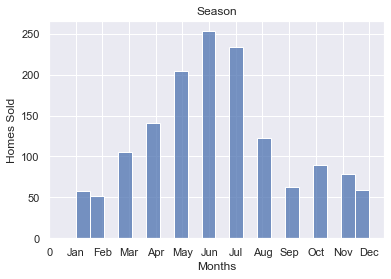

In [5]:
sns.set()
h = sns.histplot(housing_data["MoSold"])
plt.xlabel('Months')
plt.ylabel('Homes Sold')
plt.title('Season')
h.set_xticks(range(0,13))
h.set_xticklabels(['0','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.subplots_adjust(hspace = 0.8)
plt.show()

**Commentary:** "MoSold" has a spike in months 5, 6, and 7. This variable appears to be normally distributed. Is there seasonility in sales? Is there more demand in the aforementioned months and would that demand lead to higher prices?

#### Lot Area Statistics

In [6]:
housing_data['LotArea'].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

**Commentary:** Lot size ranges from 1300 square feet to 215,245 square feet. This is a huge disparity in lot sizes, with the average at 10,516 square feet. We will further explore if there are outliers in the data that need to be discarded, so that they don't negatively impact our models.

#### Outcome Variable Statistics

In [7]:
housing_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

**Commentary:** House prices range from 34,900 dollars to 755,000 dollars. This is a huge disparity in housing prices, with the average house price at 180,921 dollars. We will further explore if there are outliers in the data that need to be discarded, so that they don't negatively impact our models.

#### Correlations

In [8]:
df_numeric = housing_data.select_dtypes(include=['int64', 'float64'])
df_category = housing_data.select_dtypes(include=['object'])

df_numeric_corr = df_numeric.corr()
df_numeric_corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [9]:
'MasVnrArea','Fireplaces','LotFrontage','WoodDeckSF'

('MasVnrArea', 'Fireplaces', 'LotFrontage', 'WoodDeckSF')

#### Correlation - Heatmap

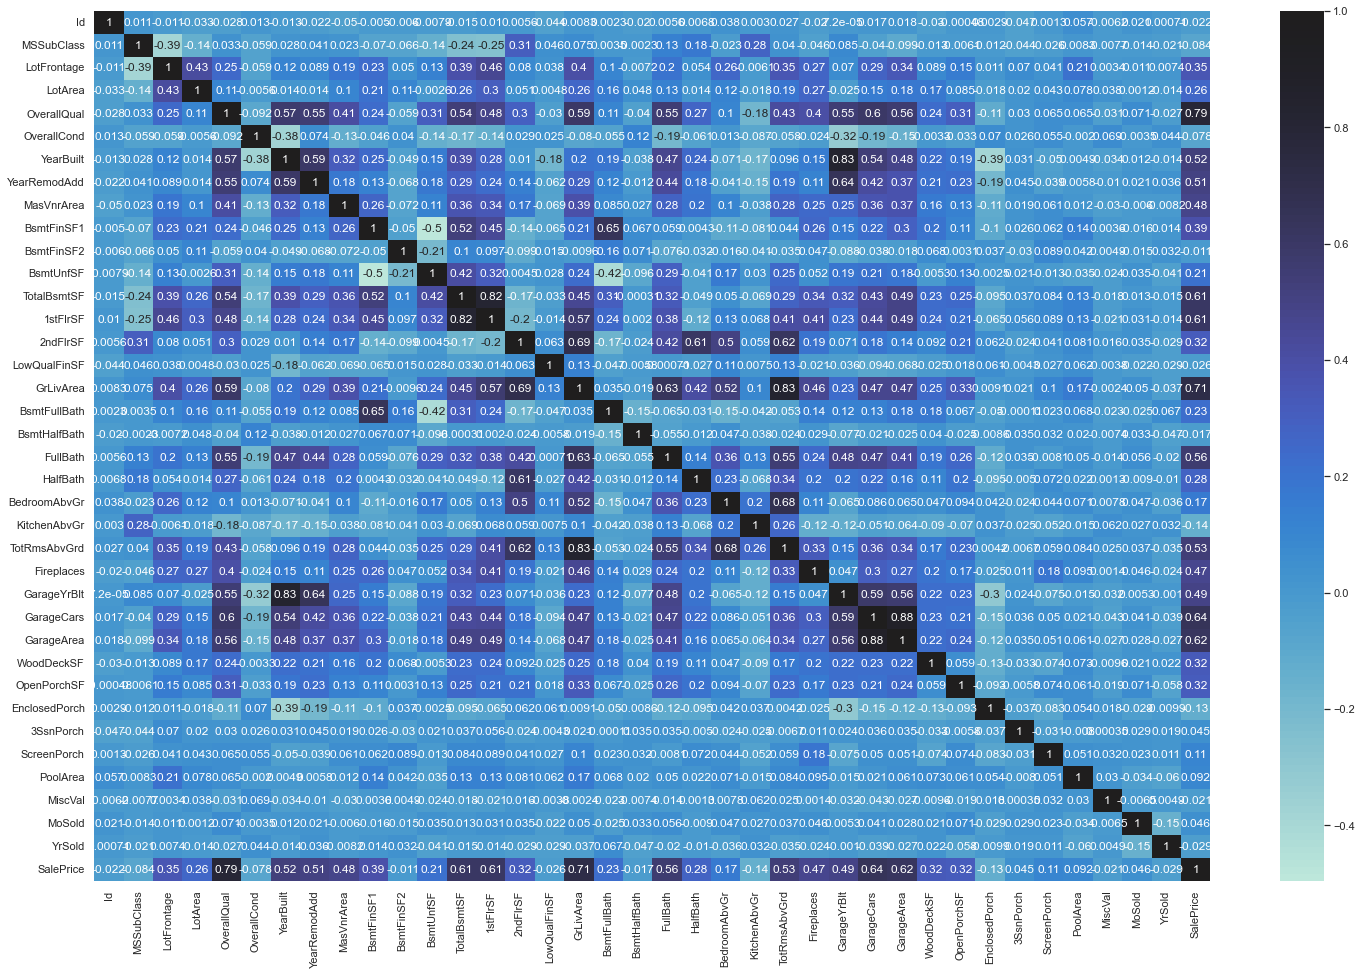

In [10]:
plt.figure(figsize=(25,16))
sns.heatmap(df_numeric.corr(),annot=True, center=1)
plt.show()

**Commentary:** The following features are greater than 50% correlated with the Home Sale Price:
- OverallQual
- GrLivArea        
- GarageCars             
- TotalBsmtSF      
- 1stFlrSF         
- FullBath         
- TotRmsAbvGrd     
- YearBuilt        
- YearRemodAdd 

#### Correlation Scatter plot (Variable versus Sale Price)

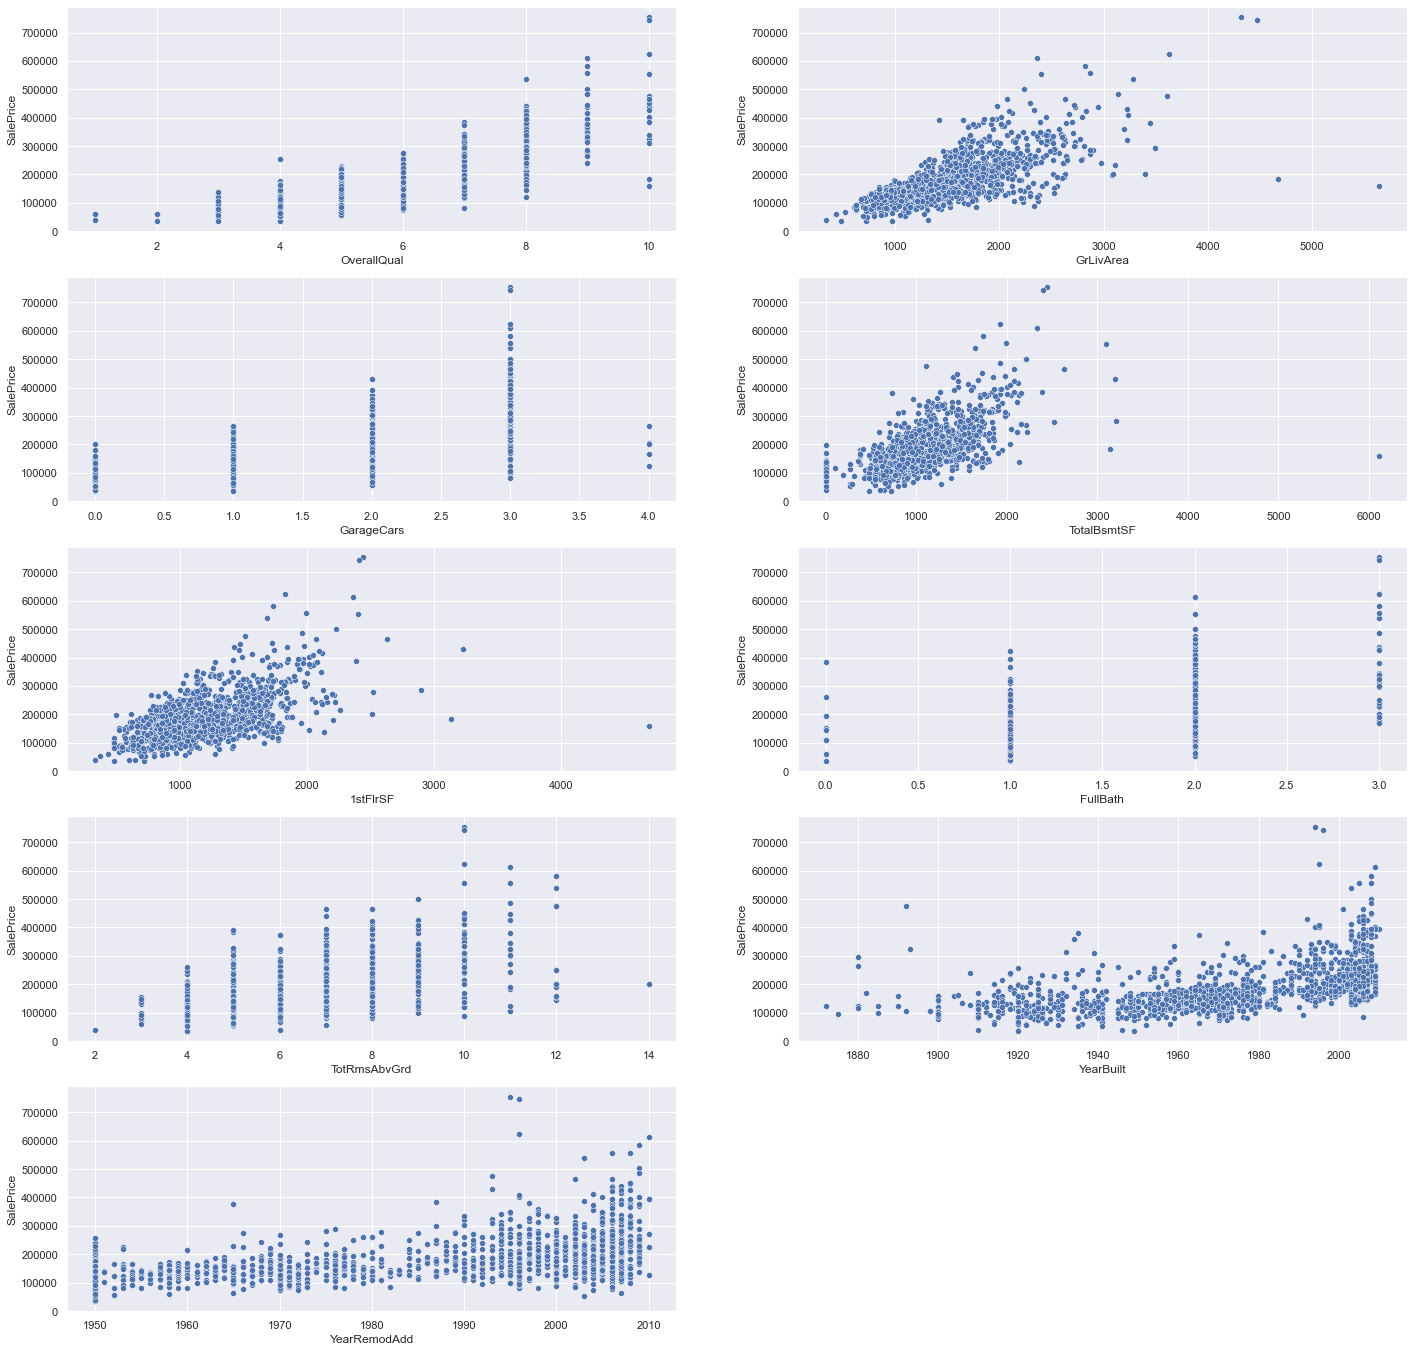

In [11]:
fig=plt.subplots(figsize=(24, 24))
i=0
correlated_features = ['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd']
for feature in correlated_features:
    i+=1
    plt.subplot(5, 2, i)
    sns.scatterplot(df_numeric[feature], df_numeric['SalePrice'])
    #plt.tight_layout()

**Commentary:** Intuitively, these variables are correlated with sales price because as these variables increase then 
sales price would increase due to:

- OverallQual - more quality
- GrLivArea - more living space       
- GarageCars - more garages to park cars          
- TotalBsmtSF - more basement space 
- 1stFlrSF - more first floor space 
- FullBath - more full bathrooms       
- TotRmsAbvGrd - more rooms above ground, perhaps better air quality   
- YearBuilt - the more recent that the home is built, the trendier       
- YearRemodAdd - more recent remods that are trendier

From a business perspective, it appears that "more" and "recent" for this collection of variables, leads to higher home prices.

#### Box plots for garage categorical features
Number of garages is correlated with a higher sales price, but what about the type of garage, it's finish, the quality, and condition? Do these categorical variables influence prices?

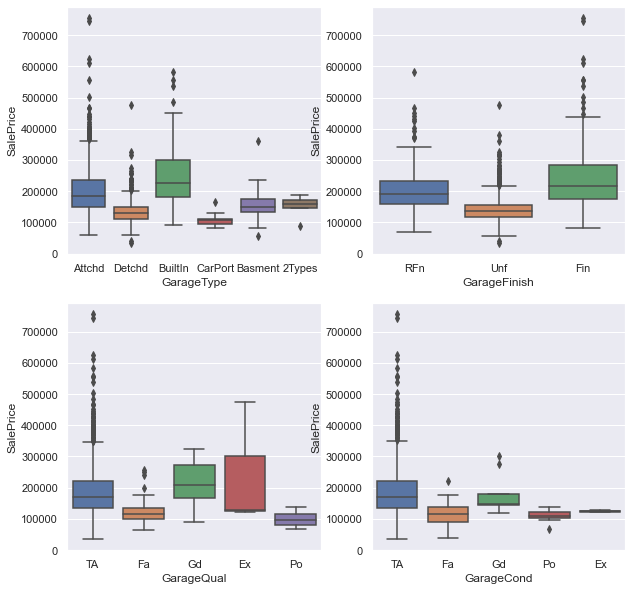

In [12]:
fig=plt.subplots(figsize=(10,10))
i=0
correlated_features = ['GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond']
for feature in correlated_features:
    i+=1
    plt.subplot(2,2, i)
    sns.boxplot(housing_data[feature], housing_data['SalePrice'])

**Commentary:** 
- The Median Value of Built-in Garages are higher
- Garage conditions do not seem to significantly affect the home prices

#### Zoning of Properties

Text(0.5, 1.0, 'Price Variance Due to Zoning')

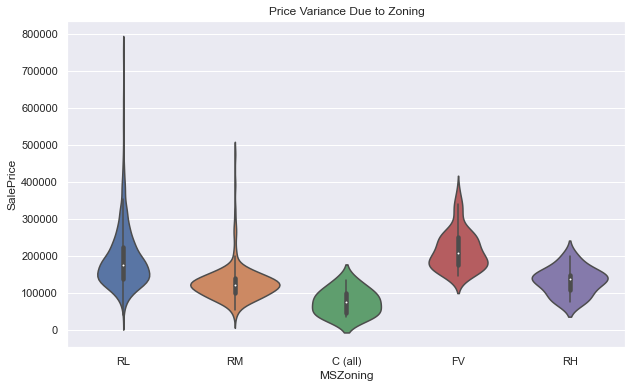

In [13]:
housing_data['MSZoning'].unique()
plt.figure(figsize=(10,6))
sns.violinplot(y='SalePrice', x='MSZoning', data=housing_data)
plt.title('Price Variance Due to Zoning')

**Commentary:** Residential properties have a huge variance relative to the other property types.
Additionally, there are multiple property types. Our intent is not to create a general model, which 
would lead to a high RMSE. We would like to create a focused model that is grounded by a specific business
case, e.g. predicting residential housing prices. As such, we will determine for the final submission if
we want to remove from our analysis certain property types.


#### Missing Data

In [14]:
data_null = housing_data.isnull().sum().sort_values(ascending=False)
total_count = housing_data.isnull().count()
data_missing_percent = (data_null/total_count*100).sort_values(ascending=False)
data_missing = pd.concat([data_null,data_missing_percent],axis=1,keys=['Data Missing','%'])
data_missing.head(20)

,Data Missing,%
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


**Commentary:** These features are missing data. There are options for dealing with missing data:
1. Discard the columns
2. Discard the rows
3. Use KNN to identify houses that are similar and use their values to populate missing values
4. Replace missing data with an average value, etc.

We evaluated all of these options and leveraging the average value gave us the best results and allowed us to retain more data (versus discarding columns or rows).

### Step 3: Pre-Process Data

In [15]:
df = housing_data
df = pd.get_dummies(df)
original_num_records = df.shape[0]

# fill missing values with average of each column
df = df.fillna(df.mean(axis=0))

# fill missing values with KNN
#imputer = KNNImputer(n_neighbors=5)
#df[:]= imputer.fit_transform(df)

# test that missing values have been removed
data_null = df.isnull().sum().sort_values(ascending=False)
total_count = df.isnull().count()
data_missing_percent = (data_null/total_count*100).sort_values(ascending=False)
data_missing = pd.concat([data_null,data_missing_percent],axis=1,keys=['Data Missing','%'])
data_missing.head(20)

# selecting rows based on houses greater than 400000
# houses_400K_df = df.loc[df['SalePrice'] > 400000]
# print(houses_400K_df )

# Filter out outliers
df.drop(df[df.SalePrice > 400000].index, inplace=True)
final_num_records = df.shape[0]

percent_excluded_records = round(((original_num_records - final_num_records) / original_num_records) * 100,2)

print("The % of records removed:", percent_excluded_records,"%")



The % of records removed: 1.92 %


**Commentary:** The action items identified by the EDA were treated by:
1. Address missing values: filled missing values with average values.
2. Address object values: used pandas get_dummies function to convert categorical data into indicator variables (one hot encoding).
3. Sales Price rightly-skewed: remove house prices greater than 400,000. This removes the skewness as these houses are outliers compared to the rest of the houses. Also, these houses represent less than 2% of the data, so from a cost benefit perspective, we aren't losing that much data but we are losing the skewness that may distort our results.

### Correlation with quantitative and qualitative variables

In [16]:
pd.options.display.max_rows = 4000
df_numeric_corr = df.corr()
df_numeric_corr['SalePrice'].sort_values(ascending=False)

SalePrice                1.000000
OverallQual              0.794784
GrLivArea                0.663579
GarageCars               0.646759
GarageArea               0.624492
TotalBsmtSF              0.575020
1stFlrSF                 0.564498
YearBuilt                0.558338
FullBath                 0.556311
ExterQual_Gd             0.541013
YearRemodAdd             0.538547
Foundation_PConc         0.519156
GarageYrBlt              0.483788
TotRmsAbvGrd             0.480354
BsmtQual_Ex              0.467482
Fireplaces               0.465572
HeatingQC_Ex             0.441691
BsmtFinType1_GLQ         0.435017
KitchenQual_Gd           0.429207
GarageFinish_Fin         0.411498
MasVnrArea               0.402552
GarageType_Attchd        0.401291
KitchenQual_Ex           0.393824
FireplaceQu_Gd           0.360843
Neighborhood_NridgHt     0.360493
BsmtQual_Gd              0.340114
BsmtFinSF1               0.336440
Exterior2nd_VinylSd      0.335891
Exterior1st_VinylSd      0.335777
ExterQual_Ex  

**Commentary:** The categorical variables basement "ExterQual_Gd" and "Foundation_PConc" are showing correlations with the sale price

#### Feature Engineering

In [17]:
# Compute VIF to detect multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['YearBuilt', 'YearRemodAdd']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

# YearBuilt and YearRemodAdd show a high degree of multi-collinearity. Intuitively, an old house
# can have a remod and appear to look new, so let's create a new feature

# take the later of the year built or the year that remod added and put that in a new column
df["LaterOfYearBuilt_RemodAdd"] = df[["YearBuilt", "YearRemodAdd"]].max(axis=1)

# Let's add variables that appear to be important to create one variable that provides the
# true magnitude of how big a house really is

# add the General Living Area and Total Basement Square Footage
df["LivArea_Basement_Garge_SF"] = df["GrLivArea"] + df["TotalBsmtSF"] + df['GarageArea']

# Let's create models for a dataset with engineered features and valuable features that show correlation
# with the sale price such as OverallQual and FullBath

        feature          VIF
0     YearBuilt  6461.946732
1  YearRemodAdd  6461.946732


### Normalize Data 
Work on normalizing all quantitative data. 
Can normalize data by assigning a Z-score or dividing by the mean, etc. 

In [18]:
#create a function for min_max
def min_max(x):
    return (x-x.min())/(x.max()-x.min())

#create a functioin for zscore
def z_score(x):
    return (x-x.mean())/x.std()

#copy dfs for adjustment 
df_adj_mm = df.copy()
df_adj_z = df.copy()

#min_max norm
df_adj_mm[df.columns[df.columns != 'SalePrice']] = \
df_adj_mm[df.columns[df.columns != 'SalePrice']].apply(min_max, axis = 0)

#zscore norm
df_adj_z[df.columns[df.columns != 'SalePrice']] = \
df_adj_z[df.columns[df.columns != 'SalePrice']].apply(z_score, axis = 0)



### Step 4: Split Data
1. Split data with all variables into training and test set
2. Split data with selected quantitative variables that have been identified with a high correlation to sales price from the EDA

We will train and evaluate both sets of data

In [19]:
housing_data_output = df['SalePrice']
housing_data_predictors = df.loc[:, df.columns != 'SalePrice']


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(housing_data_predictors, housing_data_output, test_size = 0.2, random_state = 42)
x_train_selected = x_train[['OverallQual', 'GrLivArea','GarageCars','YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'FullBath','TotRmsAbvGrd']]
x_test_selected = x_test[['OverallQual', 'GrLivArea', 'GarageCars','YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'FullBath','TotRmsAbvGrd']]


Split with adjusted data to test min-max normalization.

In [21]:
housing_data_output_mm = df_adj_mm['SalePrice']
housing_data_predictors_mm = df_adj_mm.loc[:, df.columns != 'SalePrice']

In [22]:
x_train_mm, x_test_mm, y_train_mm, y_test_mm = train_test_split(housing_data_predictors_mm, housing_data_output_mm, test_size = 0.2, random_state = 42)
x_train_selected_mm = x_train_mm[['OverallQual', 'GrLivArea','GarageCars','YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'FullBath','TotRmsAbvGrd']]
x_test_selected_mm = x_test_mm[['OverallQual', 'GrLivArea', 'GarageCars','YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'FullBath','TotRmsAbvGrd']]


Now split for zscore norm

In [23]:
housing_data_output_z = df_adj_z['SalePrice']
housing_data_predictors_z = df_adj_z.loc[:, df.columns != 'SalePrice']

In [24]:
x_train_z, x_test_z, y_train_z, y_test_z = train_test_split(housing_data_predictors_z, housing_data_output_z, test_size = 0.2, random_state = 42)
x_train_selected_z = x_train_z[['OverallQual', 'GrLivArea','GarageCars','YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'FullBath','TotRmsAbvGrd']]
x_test_selected_z = x_test_z[['OverallQual', 'GrLivArea', 'GarageCars','YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'FullBath','TotRmsAbvGrd']]

### Step 5: Evaluation Metric Selection

Ultimately, we are trying to predict the housing prices, which is a regression exercise. There are 2 well known evaluation metrics for evaluating regression, namely R Squared and Root Mean Squared Error (RMSE). Both of these metrics provide the "goodness of the fit" or how well a model fits a provided data set. For our models, we will use RMSE because are interested in learning how much our predicted home prices (on average) deviate from the actual home prices. 

### Step 6: Build Models (all features and selected features)
1. Train models with training data
2. Evaluate models using RMSE metric with test data

### Step 6A: K Nearest Neighbor (KNN) Regressor
The why? KNN tries to identify the association between the predictor variables and the outcome variable by looking at the observations that are in the same neighborhood or near each other using a function such as distance. We learned about KNN for classification in the course, and it made sense to use it for regression to identify homes that might be in the same price range due to their similarities in attributes such as number of garages, their sizes, etc.

#### Run Model on All Variables

#### Uniform Weights - Without Normalization

In [25]:
# loop through different number of neighbors to identify best neighbors value

# train the model (specify uniform as distance)

# per SKlearn: ‘uniform’ : All points in each neighborhood are weighted equally.

neighs = [5,7,8,9,10,15,20,25]
print('Distance Weights:')
for i in neighs:
    KNN = KNeighborsRegressor(n_neighbors=i, weights = 'uniform')
    #train model for hs features
    KNN.fit(x_train, y_train)
    pred = KNN.predict(x_test)
    RMSE = np.sqrt(mean_squared_error(y_test,pred))
    print("RMSE for all Features with " + str(i) + " neighbors and uniform weights: "+str(RMSE))


Distance Weights:
RMSE for all Features with 5 neighbors and uniform weights: 36423.28089648502
RMSE for all Features with 7 neighbors and uniform weights: 35881.418367960825
RMSE for all Features with 8 neighbors and uniform weights: 36140.858626311856
RMSE for all Features with 9 neighbors and uniform weights: 36548.943765754826
RMSE for all Features with 10 neighbors and uniform weights: 36556.89222687783
RMSE for all Features with 15 neighbors and uniform weights: 36293.75265540209
RMSE for all Features with 20 neighbors and uniform weights: 37036.15364515439
RMSE for all Features with 25 neighbors and uniform weights: 37266.172531704695


#### Uniform Weights - Min-Max Normalization

In [26]:
# X variables are normalized but the Y variable is not normalized

# loop through different number of neighbors to identify best neighbors value

# train the model (specify uniform as distance)

# per SKlearn: ‘uniform’ : All points in each neighborhood are weighted equally.

neighs = [5,7,8,9,10,15,20,25]
print('Distance Weights:')
for i in neighs:
    KNN = KNeighborsRegressor(n_neighbors=i, weights = 'uniform')
    #train model for hs features
    KNN.fit(x_train_mm, y_train)
    pred = KNN.predict(x_test_mm)
    RMSE = np.sqrt(mean_squared_error(y_test,pred))
    print("RMSE for all Features with " + str(i) + " neighbors and uniform weights: "+str(RMSE))

Distance Weights:
RMSE for all Features with 5 neighbors and uniform weights: 37500.00927367133
RMSE for all Features with 7 neighbors and uniform weights: 37962.50201356766
RMSE for all Features with 8 neighbors and uniform weights: 38002.72958567581
RMSE for all Features with 9 neighbors and uniform weights: 37641.17512895609
RMSE for all Features with 10 neighbors and uniform weights: 37383.41906171036
RMSE for all Features with 15 neighbors and uniform weights: 38065.55437971852
RMSE for all Features with 20 neighbors and uniform weights: 38288.38489370198
RMSE for all Features with 25 neighbors and uniform weights: 38604.599434783384


#### Uniform Weights - Z-Score Normalization

In [27]:
# X variables are normalized but the Y variable is not normalized

# loop through different number of neighbors to identify best neighbors value

# train the model (specify uniform as distance)

# per SKlearn: ‘uniform’ : All points in each neighborhood are weighted equally.

neighs = [5,7,8,9,10,15,20,25]
print('Uniform Weights-z:')
for i in neighs:
    KNN = KNeighborsRegressor(n_neighbors=i, weights = 'uniform')
    #train model for hs features
    KNN.fit(x_train_z, y_train)
    pred = KNN.predict(x_test_z)
    RMSE = np.sqrt(mean_squared_error(y_test,pred))
    print("RMSE for all Features with " + str(i) + " neighbors and uniform weights: "+str(RMSE))

Uniform Weights-z:
RMSE for all Features with 5 neighbors and uniform weights: 35389.595637545644
RMSE for all Features with 7 neighbors and uniform weights: 35289.642687007705
RMSE for all Features with 8 neighbors and uniform weights: 35000.1116356848
RMSE for all Features with 9 neighbors and uniform weights: 34827.87702428243
RMSE for all Features with 10 neighbors and uniform weights: 34852.11015671631
RMSE for all Features with 15 neighbors and uniform weights: 35902.68797175106
RMSE for all Features with 20 neighbors and uniform weights: 36603.64593105294
RMSE for all Features with 25 neighbors and uniform weights: 37303.10229883437


#### Distance Weights - Data without Adjustments

In [28]:
# loop through different number of neighbors to identify best neighbors value

# train the model (specify weights as distance)

# Per SKlearn: ‘distance’ : weight points by the inverse of their distance. 
# in this case, closer neighbors of a query point will have a greater influence 
# than neighbors which are further away‘distance’ : weight points by the inverse 
# of their distance. in this case, closer neighbors of a query point will have a 
# greater influence than neighbors which are further away

neighs = [5,7,8,9,10,15,20,25]
print('Distance Weights:')
for i in neighs:
    KNN = KNeighborsRegressor(n_neighbors=i, weights = 'distance')
    #train model for hs bfeatures
    KNN.fit(x_train, y_train)
    pred = KNN.predict(x_test)
    RMSE = np.sqrt(mean_squared_error(y_test,pred))
    print("RMSE for all Features with " + str(i) + " neighbors and distance weights: "+str(RMSE))
    

Distance Weights:
RMSE for all Features with 5 neighbors and distance weights: 36441.90623846745
RMSE for all Features with 7 neighbors and distance weights: 35778.60888414454
RMSE for all Features with 8 neighbors and distance weights: 35932.06997514665
RMSE for all Features with 9 neighbors and distance weights: 36270.504785636265
RMSE for all Features with 10 neighbors and distance weights: 36282.34127254459
RMSE for all Features with 15 neighbors and distance weights: 35833.66219666272
RMSE for all Features with 20 neighbors and distance weights: 36422.120192791226
RMSE for all Features with 25 neighbors and distance weights: 36587.70630085227


#### Distance Weights - Min-Max Normalization

In [29]:
# X and Y variables are normalized

# loop through different number of neighbors to identify best neighbors value

# train the model (specify uniform as distance)

# per SKlearn: ‘uniform’ : All points in each neighborhood are weighted equally.

neighs = [5,7,8,9,10,15,20,25]
print('Distance Weights - z:')
for i in neighs:
    KNN = KNeighborsRegressor(n_neighbors=i, weights = 'distance')
    #train model for hs features
    KNN.fit(x_train_z, y_train_z)
    pred = KNN.predict(x_test_z)
    RMSE = np.sqrt(mean_squared_error(y_test_z,pred))
    print("RMSE for all Features with " + str(i) + " neighbors and uniform weights: "+str(RMSE))

Distance Weights - z:
RMSE for all Features with 5 neighbors and uniform weights: 35160.54102514892
RMSE for all Features with 7 neighbors and uniform weights: 35061.05921004928
RMSE for all Features with 8 neighbors and uniform weights: 34761.33664964496
RMSE for all Features with 9 neighbors and uniform weights: 34566.42430798891
RMSE for all Features with 10 neighbors and uniform weights: 34582.134085951395
RMSE for all Features with 15 neighbors and uniform weights: 35441.759308283086
RMSE for all Features with 20 neighbors and uniform weights: 36035.366287045355
RMSE for all Features with 25 neighbors and uniform weights: 36704.78475025357


**Commentary:** Specifying "distance" as the weight and 5 neighbors produced the lowest RMSE. Let's leverage the "distance" improvement to run the model against the selected variables.

#### Run Model on Selected Variables - Data without Normalization

In [30]:
# loop through different number of neighbors to identify best neighbors value

# train the model (specify weights as distance)

neighs = [5,7,8,9,10,15,20,25]
print('Distance Weights:')
for i in neighs:
    KNN = KNeighborsRegressor(n_neighbors=i, weights = 'distance')
    #train model for hs features
    KNN.fit(x_train_selected, y_train)
    pred = KNN.predict(x_test_selected)
    RMSE = np.sqrt(mean_squared_error(y_test, pred))
    print("RMSE for all Features with " + str(i) + " neighbors and distance weights: "+str(RMSE))

Distance Weights:
RMSE for all Features with 5 neighbors and distance weights: 36367.58191929431
RMSE for all Features with 7 neighbors and distance weights: 36170.31061079766
RMSE for all Features with 8 neighbors and distance weights: 35715.16214214907
RMSE for all Features with 9 neighbors and distance weights: 35679.09015480938
RMSE for all Features with 10 neighbors and distance weights: 35935.61604203553
RMSE for all Features with 15 neighbors and distance weights: 35659.78052621624
RMSE for all Features with 20 neighbors and distance weights: 36081.00123832818
RMSE for all Features with 25 neighbors and distance weights: 36497.993654291065


#### Run Model on Selected Variables - Data with Min-Max Normalization

In [31]:
# X and Y variables are normalized 

# loop through different number of neighbors to identify best neighbors value

# train the model (specify weights as distance)

neighs = [5,7,8,9,10,15,20,25]
print('Distance Weights:')
for i in neighs:
    KNN = KNeighborsRegressor(n_neighbors=i, weights = 'distance')
    #train model for hs features
    KNN.fit(x_train_selected_mm, y_train_mm)
    pred = KNN.predict(x_test_selected_mm)
    RMSE = np.sqrt(mean_squared_error(y_test_mm, pred))
    print("RMSE for all Features with " + str(i) + " neighbors and distance weights: "+str(RMSE))

Distance Weights:
RMSE for all Features with 5 neighbors and distance weights: 29743.602552694258
RMSE for all Features with 7 neighbors and distance weights: 29151.686548201815
RMSE for all Features with 8 neighbors and distance weights: 28959.226048471293
RMSE for all Features with 9 neighbors and distance weights: 29242.876689585766
RMSE for all Features with 10 neighbors and distance weights: 28742.65320045601
RMSE for all Features with 15 neighbors and distance weights: 28863.29603031797
RMSE for all Features with 20 neighbors and distance weights: 28809.69106775287
RMSE for all Features with 25 neighbors and distance weights: 29006.91769132096


#### Run Model on Selected Variables - Data with Z-Score Normalization

In [32]:
# X and Y variables are normalized 

# loop through different number of neighbors to identify best neighbors value

# train the model (specify weights as distance)

neighs = [5,7,8,9,10,15,20,25]
print('Distance Weights:')
for i in neighs:
    KNN = KNeighborsRegressor(n_neighbors=i, weights = 'distance')
    #train model for hs features
    KNN.fit(x_train_selected_z, y_train_z)
    pred = KNN.predict(x_test_selected_z)
    RMSE = np.sqrt(mean_squared_error(y_test_z, pred))
    print("RMSE for selected Features with " + str(i) + " neighbors and distance weights: "+str(RMSE))

Distance Weights:
RMSE for selected Features with 5 neighbors and distance weights: 27940.01357780261
RMSE for selected Features with 7 neighbors and distance weights: 27675.839065734122
RMSE for selected Features with 8 neighbors and distance weights: 27275.613896092633
RMSE for selected Features with 9 neighbors and distance weights: 26691.546574128264
RMSE for selected Features with 10 neighbors and distance weights: 26968.592006524847
RMSE for selected Features with 15 neighbors and distance weights: 26901.426658378685
RMSE for selected Features with 20 neighbors and distance weights: 27162.891889707316
RMSE for selected Features with 25 neighbors and distance weights: 27125.827031847846


**Commentary:** Normalizing with the min/max algorithm significantly reduced error against un-normalized data. Specifying "distance" as the weight and 9 neighbors produced the lowest RMSE overall. 

### Step 6B: Decision Tree Regressor
The why? As we learned in class, the decision tree emulates how humans make decisions by going through a series of questions in their minds. For example, if I have a large family then I want a large living area. House X has a large living area, but I have multiple cars and it has only 2 garages but House Y has 3 garages. 

#### All Variables without Normalization

In [33]:
from sklearn.tree import DecisionTreeRegressor

#train a basic decision tree regressor
DT = DecisionTreeRegressor()
DT.fit(x_train, y_train)

#make predictionis and then assess r-squared and RMSE
pred = DT.predict(x_test)
RMSE = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE for basic Decision Tree Regressor: " + str(RMSE))

RMSE for basic Decision Tree Regressor: 37568.91410994862


In [76]:
#train a basic decision tree regressor
DT = DecisionTreeRegressor()
DT.fit(x_train_selected, y_train)

#make predictionis and then assess r-squared and RMSE
pred = DT.predict(x_test_selected)
RMSE = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE for basic Decision Tree Regressor: " + str(RMSE))

RMSE for basic Decision Tree Regressor: 36357.59053013802


#### All Variables with Z-Score Normalization

In [34]:
# X and Y variables are normalized 

from sklearn.tree import DecisionTreeRegressor

#train a basic decision tree regressor
DT = DecisionTreeRegressor()
DT.fit(x_train_z, y_train_z)

#make predictionis and then assess r-squared and RMSE
pred = DT.predict(x_test_z)
RMSE = np.sqrt(mean_squared_error(y_test_z, pred))
print("RMSE for basic Decision Tree Regressor: " + str(RMSE))

RMSE for basic Decision Tree Regressor: 34963.62456508511


#### All Variables with Min-Max Normalization

In [35]:
# X and Y variables are normalized 

from sklearn.tree import DecisionTreeRegressor

#train a basic decision tree regressor
DT = DecisionTreeRegressor()
DT.fit(x_train_mm, y_train_mm)

#make predictionis and then assess r-squared and RMSE
pred = DT.predict(x_test_mm)
RMSE = np.sqrt(mean_squared_error(y_test_mm, pred))
print("RMSE for basic Decision Tree Regressor: " + str(RMSE))

RMSE for basic Decision Tree Regressor: 35230.68518492513


#### Selected Variables without Normalization

In [36]:
# X variables are normalized but the Y variable is not normalized

from sklearn.tree import DecisionTreeRegressor

#train a basic decision tree regressor
DT = DecisionTreeRegressor()
DT.fit(x_train_selected, y_train)

#make predictionis and then assess r-squared and RMSE
pred = DT.predict(x_test_selected)
RMSE = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE for basic Decision Tree Regressor: " + str(RMSE))

RMSE for basic Decision Tree Regressor: 35334.5316982042


#### Selected Variables with Min-Max Normalization

In [37]:
# X variables are normalized but the Y variable is not normalized

from sklearn.tree import DecisionTreeRegressor

#train a basic decision tree regressor
DT = DecisionTreeRegressor()
DT.fit(x_train_selected_mm, y_train)

#make predictionis and then assess r-squared and RMSE
pred = DT.predict(x_test_selected_mm)
RMSE = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE for basic Decision Tree Regressor (mm): " + str(RMSE))

RMSE for basic Decision Tree Regressor (mm): 34649.557167535495


#### Selected Variables with Z-Score Normalization

In [38]:
# X variables are normalized but the Y variable is not normalized

from sklearn.tree import DecisionTreeRegressor

#train a basic decision tree regressor
DT = DecisionTreeRegressor()
DT.fit(x_train_selected_z, y_train)

#make predictionis and then assess r-squared and RMSE
pred = DT.predict(x_test_selected_z)
RMSE = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE for basic Decision Tree Regressor (z): " + str(RMSE))

RMSE for basic Decision Tree Regressor (z): 34081.58403684191


**Commentary:** The Decision Tree Regressor with our selected variables performed the best of all of the models. These metrics change each time we train the DT. This suggests that a properly tuned Random Forrest might be particularly successful when predictinig home prices. We plan on exploring Random Forests in future iterations of model building by trying different hyperparameters suce as specifying the size of the tree (depth), number of trees, etc.

#### Selected Variables with Min-Max Normalization (both X and Y variables)

In [39]:
# X and Y variables are normalized

from sklearn.tree import DecisionTreeRegressor

#train a basic decision tree regressor
DT = DecisionTreeRegressor()
DT.fit(x_train_selected_mm, y_train_mm)

#make predictionis and then assess r-squared and RMSE
pred = DT.predict(x_test_selected_mm)
RMSE = np.sqrt(mean_squared_error(y_test_mm, pred))
print("RMSE for basic Decision Tree Regressor: " + str(RMSE))

RMSE for basic Decision Tree Regressor: 36067.43482555777


#### Selected Variables with Z-Score Normalization (both X and Y variables)

In [40]:
# X and Y variables are normalized

from sklearn.tree import DecisionTreeRegressor

#train a basic decision tree regressor
DT = DecisionTreeRegressor()
DT.fit(x_train_selected_z, y_train_z)

#make predictionis and then assess r-squared and RMSE
pred = DT.predict(x_test_selected_z)
RMSE = np.sqrt(mean_squared_error(y_test_z, pred))
print("RMSE for basic Decision Tree Regressor: " + str(RMSE))

RMSE for basic Decision Tree Regressor: 35926.14368987401


Again we see that the min-max norm yields the least error. KNN with 9 neighbors is still the best performing. 

### Step 6C: Linear Regression
The why? Linear regression is the fundamental model for regression. It made sense to have a regression model as one of our baseline models. It also allows us to establish a benchmark to later improve upon through the final project.

#### All Variables without Normalization

In [41]:
from sklearn.linear_model import LinearRegression

# train the model
lin_reg = LinearRegression()
lin_reg_model = lin_reg.fit(x_train, y_train)

In [42]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
pred_1 = lin_reg.predict(x_test)
print(pred[0:5])
print(y_test[0:5])
#print(type(y_test[0]))
#summ = y_test[:,1]-pred
#rmse =  np.square(summ).sum()
RMSE = np.sqrt(mean_squared_error(y_test,pred_1))
print("The RMSE is for all variables is: " + str(RMSE))

[215000. 254000. 192000. 144000. 153000.]
124     181000
1217    229456
471     190000
358     130000
1079    126000
Name: SalePrice, dtype: int64
The RMSE is for all variables is: 20960.523981808452


#### Run Model on Selected Variables Without Normalization

In [43]:
# train the model
lin_reg = LinearRegression()
lin_reg_model = lin_reg.fit(x_train_selected, y_train)

In [44]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
pred_lr = lin_reg.predict(x_test_selected)
RMSE = np.sqrt(mean_squared_error(y_test,pred_lr))
print("The RMSE is for selected variables is: " + str(RMSE))

The RMSE is for selected variables is: 29311.59169794369


**Commentary:** The Linear Regression model with our selected variables performed significantly better than the model with all variables. We think this model can further improve through feature engineering (creating new variables from existing variables, etc.)

### Step 7: Stacking

The why? Stacking leverages good performing models on a regression task and tries to make predictions that have better performance than any single model in the ensemble.

In [45]:
#generate a prediction for x_train_sel and test via linear regression 
pred_lr_tr = lin_reg.predict(x_train_selected)
pred_lr_test = lin_reg.predict(x_test_selected)

x_train_selected_z_stack = x_train_selected_z.copy()
x_test_selected_z_stack = x_test_selected_z.copy()

#add selected var and standardized preds to the x_train/test z data frames
x_train_selected_z_stack["lr_pred"] = z_score(pred_lr_tr)
x_test_selected_z_stack["lr_pred"] = z_score(pred_lr_test)

#check standardization
print(x_test_selected_z_stack["lr_pred"][0:5])

#re-train classifiers with new feature
DT = DecisionTreeRegressor()
DT.fit(x_train_selected_z_stack, y_train)

#make predictionis and then assess r-squared and RMSE
pred_dt_test = DT.predict(x_test_selected_z_stack)
RMSE = np.sqrt(mean_squared_error(y_test, pred_dt_test))
print("RMSE for basic Decision Tree Regressor with 'LinReg stack': " + str(RMSE))


124     0.331231
1217    0.909140
471     0.569978
358    -0.785740
1079   -0.774608
Name: lr_pred, dtype: float64
RMSE for basic Decision Tree Regressor with 'LinReg stack': 34292.724955108046


In [46]:
#now stack DT and LinReg preds into dataFrame and run KNN
pred_dt_tr = DT.predict(x_train_selected_z_stack)

#build copies to add columns
x_train_selected_z_stack2 = x_train_selected_z_stack.copy()
x_test_selected_z_stack2 = x_test_selected_z_stack.copy()

#add columns
x_train_selected_z_stack2["dt_pred"] = z_score(pred_dt_tr)
x_test_selected_z_stack2["dt_pred"] = z_score(pred_dt_test)

#sanity check
print(x_test_selected_z_stack2[["lr_pred","dt_pred"]][0:5])

#retrain classifier with new features
KNN = KNeighborsRegressor(n_neighbors=9, weights = 'distance')
KNN.fit(x_train_selected_z_stack2, y_train)
pred_knn_stack = KNN.predict(x_test_selected_z_stack2)
RMSE = np.sqrt(mean_squared_error(y_test, pred_knn_stack))
print("RMSE for selected Features with 9 neighbors and distance weights: "+str(RMSE))

       lr_pred   dt_pred
124   0.331231 -0.002301
1217  0.909140  0.545203
471   0.569978  0.621245
358  -0.785740 -0.641055
1079 -0.774608 -0.458554
RMSE for selected Features with 9 neighbors and distance weights: 26651.51599554469


**Commentary:** Now try to switch KNN and DT in the stack. 

In [47]:
#generate a prediction for x_train_sel and test via linear regression 
pred_lr_tr = lin_reg.predict(x_train_selected)
pred_lr_test = lin_reg.predict(x_test_selected)

x_train_selected_z_stack = x_train_selected_z.copy()
x_test_selected_z_stack = x_test_selected_z.copy()

#add selected var and standardized preds to the x_train/test z data frames
x_train_selected_z_stack["lr_pred"] = z_score(pred_lr_tr)
x_test_selected_z_stack["lr_pred"] = z_score(pred_lr_test)

#check standardization
print(x_test_selected_z_stack["lr_pred"][0:5])

#retrain classifier with new features
fneighs = [5,7,8,9,10,15,20,25]
for i in neighs:
    KNN = KNeighborsRegressor(n_neighbors=i, weights = 'distance')
    KNN.fit(x_train_selected_z_stack, y_train)
    pred_knn_stack = KNN.predict(x_test_selected_z_stack)
    RMSE = np.sqrt(mean_squared_error(y_test, pred_knn_stack))
    print("RMSE for selected Features with "+str(i)+ " neighbors and distance weights: "+str(RMSE))

KNN = KNeighborsRegressor(n_neighbors=10, weights = 'distance')
KNN.fit(x_train_selected_z_stack, y_train)
pred_knn_stack = KNN.predict(x_test_selected_z_stack)
RMSE = np.sqrt(mean_squared_error(y_test, pred_knn_stack))
print("\nRMSE for selected Features with 10 neighbors and distance weights: "+str(RMSE))



124     0.331231
1217    0.909140
471     0.569978
358    -0.785740
1079   -0.774608
Name: lr_pred, dtype: float64
RMSE for selected Features with 5 neighbors and distance weights: 27797.120943768092
RMSE for selected Features with 7 neighbors and distance weights: 27041.98223405051
RMSE for selected Features with 8 neighbors and distance weights: 26701.99532412832
RMSE for selected Features with 9 neighbors and distance weights: 26456.425590014544
RMSE for selected Features with 10 neighbors and distance weights: 26306.548284682725
RMSE for selected Features with 15 neighbors and distance weights: 26845.461177683104
RMSE for selected Features with 20 neighbors and distance weights: 26362.440640504396
RMSE for selected Features with 25 neighbors and distance weights: 26304.141028119084

RMSE for selected Features with 10 neighbors and distance weights: 26306.548284682725


In [48]:
#now stack KNN and LinReg preds into dataFrame and run KNN
pred_knn_tr = KNN.predict(x_train_selected_z_stack)

#build copies to add columns
x_train_selected_z_stack2 = x_train_selected_z_stack.copy()
x_test_selected_z_stack2 = x_test_selected_z_stack.copy()

#add columns
x_train_selected_z_stack2["knn_pred"] = z_score(pred_knn_tr)
x_test_selected_z_stack2["knn_pred"] = z_score(pred_knn_stack)

#sanity check
print(x_test_selected_z_stack2[["lr_pred","knn_pred"]][0:5])

#re-train classifiers with new feature
DT = DecisionTreeRegressor(random_state=36)
DT.fit(x_train_selected_z_stack2, y_train)

#pred on training data for later
pred_dt_tr = DT.predict(x_train_selected_z_stack2)

#make predictionis and then assess r-squared and RMSE
pred_dt_test = DT.predict(x_test_selected_z_stack2)
RMSE = np.sqrt(mean_squared_error(y_test, pred_dt_test))
print("RMSE for basic Decision Tree Regressor with 'LinReg/KNN stack': " + str(RMSE))


       lr_pred  knn_pred
124   0.331231  0.305605
1217  0.909140  0.882336
471   0.569978  0.250976
358  -0.785740 -0.743196
1079 -0.774608 -0.821875
RMSE for basic Decision Tree Regressor with 'LinReg/KNN stack': 26365.27176194113


**Commentary:** These results suggest that stacking results from each classifier reduced error of our DT regressor by nearly $6k.

**Commentary:** Create a random forrest using all features and selected features. Parameter discussion: using too many nodes would lead to overfitting, so we used minimum impurity decrease to determine whether to keep splitting, as opposed to splitting until we reached the end of our features. Additionally, we used the square root to determine max features to determine at each node. again this is to prevent over-fitting. We did crank the number of estimators to 1000 which improved accuracy by .7 or so. 

In [49]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor(n_estimators=1000, min_impurity_decrease=.1, max_features="sqrt",oob_score = True, random_state=42) 
#or use min purity decrease inistead of max depth, #TODO use different parameters with 
#OOB scores and then report results

#train, then print OOB score
RFR.fit(x_train, y_train)
print(RFR.oob_score_)

#pred for RMSE later
pred_dtr = RFR.predict(x_test)


0.8631909380237583


**Commentary:** Fairly decent r-squared value on the OOB score, now let's try with selected var

In [50]:
#train, then print OOB score
RFR.fit(x_train_selected, y_train)
print(RFR.oob_score_)
pred_rfr_sel = RFR.predict(x_test_selected)

0.827930207210141


**Commentary:** This received a lower score than with all features. Let's check out adaboost. Exponential loss seems to improve r-squared. Otherwise all the base parameters seem to perform best. 

In [51]:
from sklearn.ensemble import AdaBoostRegressor

#fit and train the model
Adb = AdaBoostRegressor(loss = 'exponential', random_state=42)
Adb.fit(x_train,y_train)
print(Adb.score(x_train,y_train))
pred_adb = Adb.predict(x_test)


0.8768395744053079


**Commentary:** It seems like Adaboost accounts for more variance. Let's see how each does with RMSE. 

In [52]:
RMSE_dtr = np.sqrt(mean_squared_error(y_test, pred_dtr))
RMSE_adb = np.sqrt(mean_squared_error(y_test, pred_adb))

print("RF Reg RMSE: "+str(RMSE_dtr))
print("Adb Reg RMSE: "+str(RMSE_adb))

RF Reg RMSE: 23885.484577857755
Adb Reg RMSE: 28173.469456099967


**Commentary:** Fascinating! RF regressor for the win!! Now let's see if changing features reduces error. Let's start with the selected data set. 

In [53]:
print("RF Reg RMSE with selected features: " +
     str(np.sqrt(mean_squared_error(y_test, pred_rfr_sel))))

RF Reg RMSE with selected features: 24991.91884334647


**Commentary:** Lowest yet!! Alright what if we use our standardized feature set.  

In [54]:
#train and predict based on standardized data 
RFR.fit(x_train_selected_z,y_train)
pred_rfr_sel_z = RFR.predict(x_test_selected_z)

print("RMSE of RF regressor with standardized features: "+
     str(np.sqrt(mean_squared_error(y_test, pred_rfr_sel_z))))

RMSE of RF regressor with standardized features: 24971.11483215443


 **Commentary:** Slightly better. Now what if we incorporate our stacked feature set, complete with the  prediction from our DT regressor.

In [55]:
#generate pred for training data

#copy df for test and train then add dt reg pred
x_train_selected_z_stack_full = x_train_selected_z_stack2.copy()
x_test_selected_z_stack_full = x_test_selected_z_stack2.copy()

#add test and train predictions to the stacked data set 
x_train_selected_z_stack_full['dt_pred'] = z_score(pred_dt_tr) 
x_test_selected_z_stack_full['dt_pred'] = z_score(pred_dt_test)

#now refit the regressor, predict based on stack test data, and assess error
RFR.fit(x_train_selected_z_stack_full,y_train)
pred_rfr_fullstack = RFR.predict(x_test_selected_z_stack_full)

print("RMSE of RF regressor fed selected features combined with full output stack: "+
     str(np.sqrt(mean_squared_error(y_test, pred_rfr_fullstack))))


RMSE of RF regressor fed selected features combined with full output stack: 25715.767954499468


**Commentary:** Error actually get worse with our full stack. wonder if there's any difference without a DT regressor. 

In [56]:
#now refit the regressor, predict based on stack test data, and assess error
RFR.fit(x_train_selected_z_stack2,y_train)
pred_rfr_stack2 = RFR.predict(x_test_selected_z_stack2)

print("RMSE of RF regressor fed selected features combined with full output stack: "+
     str(np.sqrt(mean_squared_error(y_test, pred_rfr_stack2))))

RMSE of RF regressor fed selected features combined with full output stack: 24931.764642293798


**Commentary:** Again no difference between full or half stack, similarly worse than simply using selected variables. Very interesting. 

#### Neural Net 

In [57]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes=(50,50,50),early_stopping=True, random_state=42)
nn.fit(x_train,y_train)
pred_nn_all = nn.predict(x_test)

print("RMSE of Neural Network regressor fed all features: "+
     str(np.sqrt(mean_squared_error(y_test, pred_nn_all))))


RMSE of Neural Network regressor fed all features: 36374.81390921846


In [58]:
nn.fit(x_train_selected,y_train)
pred_nn_sel = nn.predict(x_test_selected)

print("RMSE of Neural Network regressor fed all features: "+
     str(np.sqrt(mean_squared_error(y_test, pred_nn_sel))))

RMSE of Neural Network regressor fed all features: 41587.50470546203


**Commentary:** The neural net got worse with the selected varirables. What about with all vars normalized?

In [59]:
nn.fit(x_train_z,y_train)
pred_nn_z = nn.predict(x_test_z)

print("RMSE of Neural Network regressor fed all features: "+
     str(np.sqrt(mean_squared_error(y_test, pred_nn_z))))

RMSE of Neural Network regressor fed all features: 41568.565015963984


**Commentary:** Virtually the same as above. True to its reputation, the Random Forrest regressor seems to be as accurate as it gets. 

#### PCA

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8) # specify 8 components or dimensions
x_train_pca = pca.fit_transform(x_train) # fit pca model on train data
x_test_pca = pca.transform(x_test)


from sklearn.tree import DecisionTreeRegressor

#train a basic decision tree regressor
DT = DecisionTreeRegressor()
DT.fit(x_train_pca, y_train)

#make predictionis and then assess r-squared and RMSE
pred = DT.predict(x_test_pca)
RMSE = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE for basic Decision Tree Regressor: " + str(RMSE))

RMSE for basic Decision Tree Regressor: 42757.264135529076


**Commentary:** The model got worse with PCA (tried between 2 and 8 components)

### Step 8: Engineered Features 

**Commentary:** Select the 4 variables (2 feature engineered and 2 with high degree of correlations with Sale Price) from Feature Selection section above. From a business perspective and data analysis, it appeared that "more" and "recent" for some specific variables (house built or remodeled and the size of the house), leads to higher home prices, thus this approach makes intuitive sense.


In [61]:

x_train_selected_fe = x_train_z[['OverallQual', 'LaterOfYearBuilt_RemodAdd','LivArea_Basement_Garge_SF', 'FullBath']]
x_test_selected_fe = x_test_z[['OverallQual', 'LaterOfYearBuilt_RemodAdd','LivArea_Basement_Garge_SF', 'FullBath']]


In [62]:
# X variables are normalized but the Y variable is not normalized

# loop through different number of neighbors to identify best neighbors value

neighs = [5,7,8,9,10,15,20,25]
print('Distance Weights:')
for i in neighs:
    KNN = KNeighborsRegressor(n_neighbors=i, weights = 'distance')
    #train model for hs features
    KNN.fit(x_train_selected_fe, y_train)
    pred = KNN.predict(x_test_selected_fe)
    RMSE = np.sqrt(mean_squared_error(y_test, pred))
    print("RMSE for all Features with " + str(i) + " neighbors and distance weights: "+str(RMSE))

Distance Weights:
RMSE for all Features with 5 neighbors and distance weights: 26316.140708251613
RMSE for all Features with 7 neighbors and distance weights: 26387.192388052667
RMSE for all Features with 8 neighbors and distance weights: 26130.974707183443
RMSE for all Features with 9 neighbors and distance weights: 26058.805972274393
RMSE for all Features with 10 neighbors and distance weights: 25992.799051989845
RMSE for all Features with 15 neighbors and distance weights: 25587.062422409064
RMSE for all Features with 20 neighbors and distance weights: 25394.489318765824
RMSE for all Features with 25 neighbors and distance weights: 25363.925609586106


#### Linear Regression

In [63]:
# X variables are normalized but the Y variable is not normalized

# train the model
lin_reg = LinearRegression()
lin_reg_model = lin_reg.fit(x_train_selected_fe, y_train)

In [64]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
pred_lr = lin_reg.predict(x_test_selected_fe)
RMSE = np.sqrt(mean_squared_error(y_test,pred_lr))
print("The RMSE is for selected variables is: " + str(RMSE))

The RMSE is for selected variables is: 29688.469771683394


#### Decision Tree Regressor

In [65]:
# X variables are normalized but the Y variable is not normalized

from sklearn.tree import DecisionTreeRegressor

#train a basic decision tree regressor
DT = DecisionTreeRegressor()
DT.fit(x_train_selected_fe, y_train)

#make predictionis and then assess r-squared and RMSE
pred = DT.predict(x_test_selected_fe)
RMSE = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE for basic Decision Tree Regressor: " + str(RMSE))

RMSE for basic Decision Tree Regressor: 36693.70352995974


#### Random Forest Regressor

In [71]:
# X variables are normalized but the Y variable is not normalized

from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor(n_estimators=1000, min_impurity_decrease=.1, max_features="sqrt",oob_score = True, random_state=42) 
#or use min purity decrease inistead of max depth, #TODO use different parameters with 
#OOB scores and then report results

# train
RFR.fit(x_train_selected_fe, y_train)

# predict
pred_rfr_sel = RFR.predict(x_test_selected_fe)

RMSE_dtr = np.sqrt(mean_squared_error(y_test, pred_rfr_sel))

print("Random Forest RMSE: "+str(RMSE_dtr))



Random Forest RMSE: 25129.639393890528


**Commentary:** Leveraging the lessons from previous models, namely normalizing the X variables, KNN with Distance Weights performs best versus Uniform Weights, Random Forest performs very well overall, we selected 2 variables that showed a high correlation with the Sale Price and created 2 variables with feature engineering to apply 4 models (KNN, Decision Tree Regressor, Linear Regression and Random Forest). The Random forest model performed the best.

**Kaggle Score:** Adjusting our metric to align with Kaggle scoring. 

In [75]:
kaggle = np.log(pred_rfr_sel) - np.log(y_test)

print(kaggle[0:5])
print("Kaggle Score: " + str(np.abs(kaggle).mean()))

kaggle = np.log(pred_dtr) - np.log(y_test)

print(kaggle[0:5])
print("Kaggle Score: " + str(np.abs(kaggle).mean()))



124     0.141699
1217    0.015066
471    -0.215483
358    -0.030572
1079    0.004866
Name: SalePrice, dtype: float64
Kaggle Score: 0.11293564272454397
124    -0.031420
1217   -0.004480
471    -0.015101
358     0.069146
1079    0.097185
Name: SalePrice, dtype: float64
Kaggle Score: 0.09296948869232985
